# Here in this note book we will do some exploration of the CGL dataset 

starting by importing the neccessary packages

note : we need to install the nippy and peakutils packages but they cant be instlled using pip so the should be installed manuually

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nippy
import scipy
import peakutils
import math
from sklearn.cross_decomposition import PLSRegression
%matplotlib inline 

here we will load the three csv files containing corn samples and concatinate them into one pandas data frame, then 
 plot any data point of it 

Text(0, 0.5, 'absorbtion')

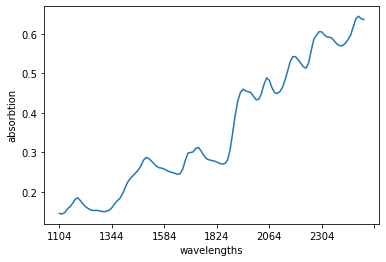

In [13]:
specs1 = pd.read_csv(r'D:\Gradution project\datasets\CGL\x_train.csv')
specs2 = pd.read_csv(r'D:\Gradution project\datasets\CGL\x_val.csv')
specs = pd.concat([specs1,specs2], axis=0)
specs = specs.sample(frac=1).reset_index(drop=True)
sample = specs.iloc[110]  
sample.plot()
plt.xlabel('wavelengths')
plt.ylabel('absorbtion')


as we can se the data is very smooth and we will consider the 'specs' data frame to be the master throughout this notebook


# here we will define some preprocessing functions

### Resampling:

the first function is used to resample the data set to reduce resolution , this could be particularly useful when trying to simulate the slave insturment with less resolution than the master 

In [14]:
def sinc_interp(x, s, u):
    if len(x) != len(s):
        raise ValueError('x and s must be the same length')
    
    # Find the period    
    T = s[1] - s[0]
    
    sincM = np.tile(u, (len(s), 1)) - np.tile(s[:, np.newaxis], (1, len(u)))
    y = np.dot(x, np.sinc(sincM/T))
    return y

In [15]:
def resample(wavelength, spectra, resampling_ratio):
    """ Resample spectra according to the resampling ratio.
    Args:
        wavelength <numpy.ndarray>: Vector of wavelengths.
        spectra <numpy.ndarray>: NIRS data matrix.
        resampling_ratio <float>: new length with respect to original length
    Returns:
        wavelength_ <numpy.ndarray>: Resampled wavelengths.
        spectra_ <numpy.ndarray>: Resampled NIR spectra
    """

    new_length = int(np.round(wavelength.size * resampling_ratio))
    spectra_, wavelength_ = scipy.signal.resample(spectra, new_length,axis=1, t=wavelength,domain='time')
    return wavelength_, spectra_
            

In [16]:
wavlength = np.array([int(i) for i in specs.columns])

In [17]:
wav,out = resample(wavlength,specs,0.5)
out = pd.DataFrame(out,columns=wav)
out.head()
#out.iloc[0].plot()

,1104.000000,1128.206897,1152.413793,1176.620690,1200.827586,1225.034483,1249.241379,1273.448276,1297.655172,1321.862069,...,2265.931034,2290.137931,2314.344828,2338.551724,2362.758621,2386.965517,2411.172414,2435.379310,2459.586207,2483.793103
0,0.315295,0.116337,0.187313,0.174075,0.201674,0.177087,0.187674,0.174896,0.179153,0.169707,...,0.592254,0.626937,0.621623,0.618610,0.611194,0.636038,0.623613,0.711857,0.750873,0.850843
1,0.250465,0.116872,0.165433,0.151171,0.164713,0.149615,0.155477,0.146146,0.149715,0.145747,...,0.456039,0.486035,0.477025,0.464237,0.455430,0.475927,0.478808,0.538257,0.547042,0.606803
2,0.235078,0.119856,0.161078,0.146292,0.156310,0.145135,0.149899,0.141551,0.144661,0.142041,...,0.412479,0.441055,0.432038,0.413616,0.405737,0.426804,0.435611,0.489261,0.490504,0.539456
3,0.245868,0.117362,0.162638,0.147481,0.160210,0.147872,0.153726,0.144753,0.147968,0.144378,...,0.431641,0.460820,0.453223,0.435740,0.429575,0.452617,0.459002,0.519605,0.527985,0.585830
4,0.271484,0.116750,0.176577,0.164374,0.181881,0.157903,0.164236,0.153584,0.158165,0.152040,...,0.540543,0.574058,0.561602,0.559401,0.543695,0.557651,0.549792,0.609842,0.623850,0.692290


In [18]:
y = sinc_interp(specs.iloc[110],np.array([int(i) for i in specs.columns]),wav)
#plt.plot(wav,y,color='red')
y

array([0.14474   , 0.14738166, 0.16244803, 0.18121279, 0.17693084,
       0.16143575, 0.15359506, 0.15287142, 0.1499678 , 0.15082151,
       0.16067799, 0.17775443, 0.1963935 , 0.22638992, 0.24158873,
       0.2564244 , 0.28246551, 0.28239808, 0.26856276, 0.25976003,
       0.25546476, 0.24885135, 0.24477456, 0.24796848, 0.28804472,
       0.29773118, 0.31135511, 0.29669194, 0.28046381, 0.27694315,
       0.27215638, 0.26866981, 0.28851691, 0.37319948, 0.44300553,
       0.45596865, 0.45104015, 0.43350527, 0.44082258, 0.48362627,
       0.46736229, 0.44656375, 0.45838071, 0.49815917, 0.53904669,
       0.53434056, 0.51590256, 0.52028014, 0.58160992, 0.60217739,
       0.59574532, 0.58939812, 0.57832209, 0.56728415, 0.57358205,
       0.59376583, 0.63512469, 0.63551005])

### Adding Noise:

the second function is used to add noise and baseline shifts to the spectra

In [19]:
def PolyCoefficients(values, coeffs):
    """ Returns a polynomial for ``x`` values for the ``coeffs`` provided.

    The coefficients must be in ascending order (``x**0`` to ``x**o``).
    """
    o = len(coeffs)
    y = np.zeros(values)
    x = np.array(range(values))
    
    for i in range(o):
        y = y + coeffs[i]*x**i
        
    return y

In [20]:
def addnoise3(df,snr):
    specs = df.copy()
    columns = list(specs.columns)
    specs = specs.to_numpy()
    noise_standardDeviation = 1/math.pow(10,(snr/10))
    for i in range(specs.shape[0]):
        specs[i] = specs[i] + np.random.normal(0, noise_standardDeviation, specs.shape[1])
        
    specs = pd.DataFrame(specs,columns=columns)
    return specs    
    

Text(0, 0.5, 'absorbtion')

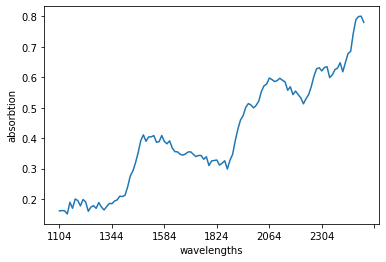

In [35]:
specs_noised = addnoise3(specs.copy(deep=True),20)
sample = specs_noised.iloc[0]
sample.plot()
plt.xlabel('wavelengths')
plt.ylabel('absorbtion')

### smoothing:

here we will create a nippy pipe line which contains only the smoothing function with filteration window=35

we can do that by creating the 'test.ini' file as follows:

[SMOOTH]


    filter_win = 5
    window_type = hamming

the smoothing function works by swaping the spectra with  a filter using convolution
the filter_win parameter controls the window size of the filter
the window size should vary depending on the both the resolution of the spectra and the standard deviation of the noise added

for the resolution of this data and the standard dev =[0.001-0.1] the windoe of [15-35] should work fine

the window_type is the type of the window which is convoluted to the spectra but we found hamming filter to be working fine

In [36]:
# 1. Load configuration
pipelines = nippy.read_configuration('conf1.ini')

# 2. Load data
data = specs_noised.to_numpy()
wavelength = [int(wav) for wav in specs_noised.columns]
wavelength = np.array(wavelength)
spectra = data[:, :].T  # Rows = wavelength, Columns = samples 

# 3. Dataset through all pipelines
datasets = nippy.nippy(wavelength, spectra, pipelines)

# 4. Export the preprocessed data (showcasing three variants)
nippy.export_pipelines_to_csv('D:\Gradution project\datasets\corn\preprocessed_data', datasets, pipelines, mkdir=True)

Running pipe 1:
{'SMOOTH': {'filter_win': 5, 'window_type': 'hamming'}}



this will generate csv file of the filtered data in the specified loctaion

now lets plot the data after filteration

Text(0, 0.5, 'absorbtion')

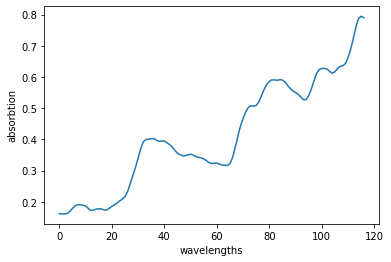

In [46]:
specs_filtered = pd.read_csv('D:\Gradution project\datasets\corn\preprocessed_data\p1.csv',header=None)
specs_filtered = specs_filtered.drop(0,axis=1).T
#specs_filtered.columns = [str(i) for i in range(1104,2497,12)]
sample = specs_filtered.iloc[0]
sample.plot()
plt.xlabel('wavelengths')
plt.ylabel('absorbtion')

as we can see the data is smooth but its still not quite look like the master

### Baseline removal:

now we can remove the baseline shifts in the data using peakutils package

here we can use this function which fits a polynomial of the the order we decide to the local minima of the spectrum , then we can simply subtract this base line from the spectrum 

In [47]:
def remove_baseline(spectra,fit_order):
    base = peakutils.baseline(spectra.iloc[0], fit_order)
    for i in range(spectra.shape[0]):
        spectra.iloc[i] = spectra.iloc[i] - base
    
    return spectra

<AxesSubplot:>

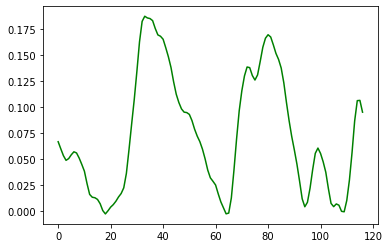

In [48]:
slave = remove_baseline(specs_filtered,4)
slave.iloc[0].plot(color="green")

so this the data after the baseline removal 

# Standard Free Calipration:

the standard free calibration methods means that we dont have the same samples on both insturment so we cant crete a model to

map between the two insturments spectra, so what we can do is try the previous preprocessing methods to make the slave spectra 

look more like the master

we will now try to create the slave spectra by adding noise and  a baseline shift:

Text(0, 0.5, 'absorbtion')

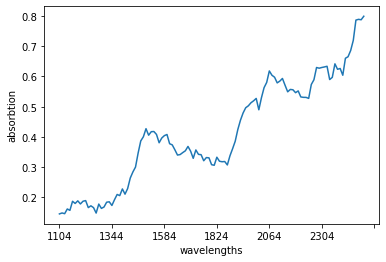

In [56]:
slave = addnoise3(specs.copy(deep=True),20)
sample = slave.iloc[0]
sample.plot()
plt.xlabel('wavelengths')
plt.ylabel('absorbtion')

#### now we will resample the spectra to reduce the slave resolution to 10% of the master

#### Now will try to remove those effects from the slave so it looks more like the master

First we will apply smoothing function to smooth out the noise  

In [57]:
# 1. Load configuration
pipelines = nippy.read_configuration('conf1.ini')

# 2. Load data
data = slave.to_numpy()
wavelength = data[0, :]
spectra = data[:, :].T  # Rows = wavelength, Columns = samples 

# 3. Dataset through all pipelines
datasets = nippy.nippy(wavelength, spectra, pipelines)

# 4. Export the preprocessed data (showcasing three variants)
nippy.export_pipelines_to_csv('D:\Gradution project\datasets\corn\preprocessed_data', datasets, pipelines, mkdir=True)

Running pipe 1:
{'SMOOTH': {'filter_win': 5, 'window_type': 'hamming'}}



Notice: we reduced the filter window size because we reduced our resolution


NOW lets plot the filtered spectra:

In [58]:
slave = pd.read_csv('D:\Gradution project\datasets\corn\preprocessed_data\p1.csv',header=None)
slave = slave.drop(0,axis=1).T
slave.columns = [str(int(i)) for i in wav]
sample = slave.iloc[0]
sample.plot()
plt.xlabel('wavelengths')
plt.ylabel('absorbtion')

ValueError: Length mismatch: Expected axis has 117 elements, new values have 70 elements

##### the next step is to remove the base line from the slave spectra

<AxesSubplot:>

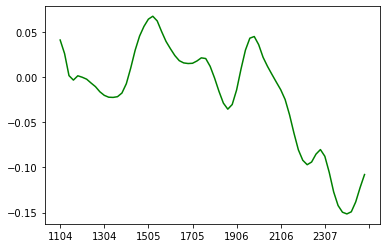

In [54]:
slave = remove_baseline(slave,2)
slave.iloc[1].plot(color="green")

here we removes all the baseline shifts from the spectra , but  now we need to add the base line of the original data so that the slave looks more like the master

In [55]:
original_base = peakutils.baseline(specs.iloc[0], 4)
base = []
for sample in range(0,len(original_base),step):
    base.append(original_base[sample])
base = np.array(base)
    
for i in range(slave.shape[0]):
        slave.iloc[i] = slave.iloc[i] + base
        
slave.iloc[0].plot(color="green")

NameError: name 'step' is not defined

lets plot the master data to compare

<AxesSubplot:>

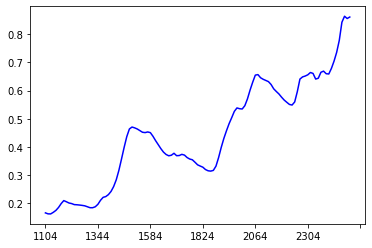

In [87]:
specs.iloc[0].plot(color="blue")

as we can see the slave some how looks like the master data

# Piece wise Direct standarization

here we implemented the PDS function to transfer from the slave to master spectra

In [88]:
def PDS(Master,Slave,Test,window_size,n_components):
    """
    Arguments:
    Master: Master Dataframe
    Slave: Slave Dataframe
    Test: Test Dataframe
    window_size : Window Size used in PDS Algorithm
    n_components : Number of Components used in PLS Algorithm
    
    Return: 
    Mapped_Output: The output dataframe after mapping slave to master
    """
    wave_lengths= list(Slave.columns)
    Mapped_Output = pd.DataFrame().reindex_like(Test)
    
    for i in range(window_size,Slave.shape[1]-window_size):
        slave_subset= Slave.loc[:,wave_lengths[i-window_size:i+window_size+1]]
        master_subset = Master.loc[:,wave_lengths[i]]
        pls = PLSRegression(n_components)
        pls.fit(slave_subset,master_subset)
        test_subset = Test.loc[:,wave_lengths[i-window_size:i+window_size+1]]
        Mapped_Output.loc[:,wave_lengths[i]] = pls.predict(test_subset)
    return Mapped_Output

Text(0, 0.5, 'absorbtion')

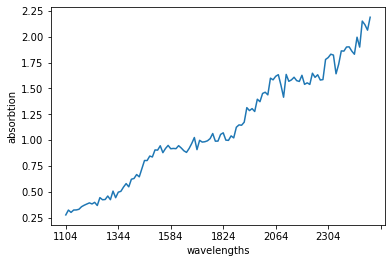

In [89]:
slave = addnoise(specs.copy(deep=True),2e-2,[1,2e-2],[1e-1,1e-2])
sample = slave.iloc[0]
sample.plot()
plt.xlabel('wavelengths')
plt.ylabel('absorbtion')

Running pipe 1:
{'SMOOTH': {'filter_win': 5, 'window_type': 'hamming'}}



<AxesSubplot:>

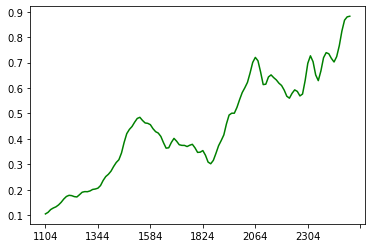

In [90]:

# 1. Load configuration
pipelines = nippy.read_configuration('conf1.ini')

# 2. Load data
data = slave.to_numpy()
wavelength = data[0, :]
spectra = data[:, :].T  # Rows = wavelength, Columns = samples 

# 3. Dataset through all pipelines
datasets = nippy.nippy(wavelength, spectra, pipelines)

# 4. Export the preprocessed data (showcasing three variants)
nippy.export_pipelines_to_csv('D:\Gradution project\datasets\corn\preprocessed_data', datasets, pipelines, mkdir=True)

slave = pd.read_csv('D:\Gradution project\datasets\corn\preprocessed_data\p1.csv',header=None)
slave = slave.drop(0,axis=1).T
slave.columns = [str(i) for i in range(1104,2497,12)]

slave = remove_baseline(slave,2)

original_base = peakutils.baseline(specs.iloc[0], 4)
base = []
for sample in range(0,len(original_base)):
    base.append(original_base[sample])
base = np.array(base)
    
for i in range(slave.shape[0]):
        slave.iloc[i] = slave.iloc[i] + base

slave.iloc[0].plot(color="green")



In [91]:
specs_train = specs[:200]
slave_train = slave[:200]
specs_test = specs[200:]
slave_test = slave[200:]

In [92]:
PDS_out = PDS(specs_train,slave_train,slave_test,4,3)

so now we will apply the PDS algorithm to transfer from this spectra to the master

<AxesSubplot:>

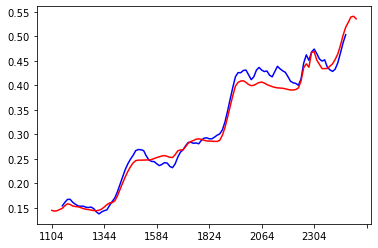

In [93]:
PDS_out.iloc[0].plot(color="blue") ## Output of PDS
specs_test.iloc[0].plot(color="red") ## Master

as we can see the predicted and the orginal data are almost identical which means that we successfully transfered from the slaver spectra to the master